For some reason, this only currently works on Windows but not on Mac OS

In [1]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [2]:
# Sensor ID	Location
# 10635576	10th Street Bridge
# 10635579	Parking Lot at the Corner of Hemphill and Ferst St
# 10635580	5th Street Bridge
# 10635581	Canopied Walkway
# 10635582	10th and Hemphill St Parking Lot
# 10635584	Crecine Hall
# 10635585	Baker Building
# 10635586	McCamish Pavilion
# 10635587	Curran St. Parking Deck
# 10635588	Constructed Wetlands
# 10635589	Stamps Field Parking
# 10635590	Grass Walkway
# 10635591	Allen Parking Lot
# 10635592	Clough Parking Loop
# 10635593	Tech Square
# 10635595	Brittain Drive
# 10635596	Tech Tower
# 10635597	Glenn Courtyard
# 10884507	Constructed Wetland Trees
# 10884521	Couch Park Walkway
# 10884524	Biology Quad Amphitheater
# 10884532	Atlanta Botanical Gardens (off campus)

In [3]:
all_sensor_IDs = [
    10635576
,   10635579
,   10635580
,   10635581
,   10635582
,   10635584
,   10635585
,   10635586
,   10635587
,   10635588
,   10635589
,   10635590
,   10635591
,   10635592
,   10635593
,   10635595
,   10635596
,   10635597
,   10884507
,   10884521
,   10884524
,   10884532
]

In [4]:
def f2c(f):
    return (f - 32) * 5 / 9

In [5]:


# Define the root directory from which to start searching
root_directory = Path.cwd()

# Create an empty list to store dataframes
header_serial_map = {}


# Convert sensor IDs to strings (if they are integers)
all_sensor_IDs = [str(sensor_id) for sensor_id in all_sensor_IDs]


# Iterate over CSV files in the root directory
for file_path in root_directory.rglob("*.csv"):
    # Get the filename without extension
    filename = file_path.stem  # stem gives the filename without the extension

    # Check if the filename starts with any of the sensor IDs
    if any(filename.startswith(sensor_id) for sensor_id in all_sensor_IDs):
        # Load the CSV file into a dataframe, setting the second row as the header

        df = pd.read_csv(file_path, header=1)

        # Clean up column names by simplifying them
        df.columns = df.columns.str.extract(r'([^,]+)')[0].str.strip()
        
        # Extract serial number from the column headers (looking for the pattern 'S/N: <number>')
        serial_numbers = set()
        for col in df.columns:
            match = re.search(r'S/N: (\d+)', col)
            if match:
                serial_numbers.add(match.group(1))

        # Remove unnecessary headers
        df = df.loc[:, ~df.columns.str.startswith('Coupler')]
        df = df.loc[:, ~df.columns.str.startswith('End Of')]
        df = df.loc[:, ~df.columns.str.startswith('Stopped')]
        df = df.loc[:, ~df.columns.str.startswith('Bad Battery')]

        if  'Date' not in df.columns:
            break
        
        
        # Check if 'DewPt' exists in the columns
        if 'DewPt' in df.columns:
            df['DewPt'] = df['DewPt'].apply(f2c)

        # Similarly, check if 'Temp' exists and convert
        if 'Temp' in df.columns:
            df['Temp'] = df['Temp'].apply(f2c)

        df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='mixed')

        
        # Ensure all serial numbers in the header are identical
        if len(serial_numbers) == 1:
            header_serial = serial_numbers.pop()
            # Add the sensor serial number as a new column
            df['Sensor_ID'] = header_serial
            # Append dataframe to the appropriate serial number list
            if header_serial not in header_serial_map:
                header_serial_map[header_serial] = []
            header_serial_map[header_serial].append(df)

# Concatenate dataframes only if they have identical header serial numbers
concatenated_dataframes = []
for serial, dfs in header_serial_map.items():
    if dfs:  # Only concatenate if there are dataframes in the list
        concatenated_dataframes.append(pd.concat(dfs, ignore_index=True))

# If there are concatenated dataframes, concatenate them all into one
if concatenated_dataframes:
    all_data = pd.concat(concatenated_dataframes, ignore_index=True)
    # Displaying the combined dataframe
    display(all_data)
else:
    print("No valid dataframes found for concatenation.")


,#,Date,Time,Temp,RH,DewPt,Datetime,Sensor_ID
0,1,04/03/15,09:18:51,19.341111,66.329,13.093889,2015-04-03 09:18:51,10635576
1,2,04/03/15,09:23:51,19.865000,65.857,13.490000,2015-04-03 09:23:51,10635576
2,3,04/03/15,09:28:51,19.817222,65.343,13.330000,2015-04-03 09:28:51,10635576
3,4,04/03/15,09:33:51,19.555000,64.344,12.856111,2015-04-03 09:33:51,10635576
4,5,04/03/15,09:38:51,20.102778,64.408,13.391111,2015-04-03 09:38:51,10635576
...,...,...,...,...,...,...,...,...
1769627,16715,06/28/17,14:10:00,27.801111,49.938,16.750000,2017-06-28 14:10:00,10884524
1769628,16716,06/28/17,14:15:00,27.751111,49.321,16.511111,2017-06-28 14:15:00,10884524
1769629,16717,06/28/17,14:20:00,28.072222,49.362,16.818889,2017-06-28 14:20:00,10884524
1769630,16718,06/28/17,14:23:25,NaN,NaN,NaN,2017-06-28 14:23:25,10884524


In [15]:

ALL_DATA = {}
for interval in ['5min', '60min']:
    for ID in all_sensor_IDs:

        temp_df = all_data[all_data['Sensor_ID'] == str(ID)]


        temp_df.set_index('Datetime', inplace=True)

        # Resample and apply different aggregations
        df_resampled = temp_df.groupby("Date").resample(interval).agg({
            'Temp': 'mean',
            'RH': 'mean',
            'DewPt': 'mean'
        })

        df_resampled = df_resampled.reset_index()
        df_resampled.index = df_resampled['Datetime']   
        df_resampled.drop(columns={'Datetime'}, inplace=True)      
        df_resampled.to_csv("{0}_CleanedWeaterStationData_{1}_Intervals.csv".format(ID, interval), float_format='%.3f')                           

        ALL_DATA[ID] = df_resampled
        

In [7]:
# Initialize common_index with the index of the first DataFrame
common_index = ALL_DATA['10635576'].index

# Iterate over the remaining DataFrames and find the intersection
for i in ALL_DATA:
    common_index =  common_index.intersection(ALL_DATA[i].index)

# Optionally, sort the common_index
common_index = common_index.sort_values()
common_index

DatetimeIndex(['2017-05-02 09:00:00', '2017-05-02 10:00:00',
               '2017-05-02 11:00:00', '2017-05-02 12:00:00',
               '2017-05-02 13:00:00', '2017-05-02 14:00:00',
               '2017-05-02 15:00:00', '2017-05-02 16:00:00',
               '2017-05-02 17:00:00', '2017-05-02 18:00:00',
               ...
               '2017-06-28 03:00:00', '2017-06-28 04:00:00',
               '2017-06-28 05:00:00', '2017-06-28 06:00:00',
               '2017-06-28 07:00:00', '2017-06-28 08:00:00',
               '2017-06-28 09:00:00', '2017-06-28 10:00:00',
               '2017-06-28 11:00:00', '2017-06-28 12:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=1372, freq='h')

In [8]:
ALL_DATA['10635576'].loc[common_index]

,Date,Temp,RH,DewPt
Datetime,,,,
2017-05-02 09:00:00,05/02/17,20.384815,42.911417,7.653472
2017-05-02 10:00:00,05/02/17,22.084676,36.412583,6.788241
2017-05-02 11:00:00,05/02/17,23.324630,32.559083,6.233889
2017-05-02 12:00:00,05/02/17,24.593426,29.015583,5.621806
2017-05-02 13:00:00,05/02/17,25.885278,25.250583,4.646111
...,...,...,...,...
2017-06-28 08:00:00,06/28/17,25.599352,57.538583,16.890000
2017-06-28 09:00:00,06/28/17,27.505741,54.051000,17.703194
2017-06-28 10:00:00,06/28/17,28.792222,49.126250,17.388843


In [9]:


def plot_time_series(df):
    """
    Plots time series of Temperature, Relative Humidity, and Dew Point from the given DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Temp', 'RH', 'DewPt' columns with datetime index.

    Returns:
    None
    """

    # Reset the index to make 'Date' and 'Datetime' columns
    df = df.reset_index()

    df.index = df['Datetime']

    # Ensure the index is datetime
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        raise ValueError("DataFrame index must be datetime.")

    # Sort the DataFrame by datetime index
    df = df.sort_index()

    # Handle missing values
    #df = df.interpolate(method='time')

    # Create a figure and axis objects
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot Temperature
    color = 'tab:red'
    ax1.set_xlabel('Date and Time')
    ax1.set_ylabel('Temperature (°C)', color=color)
    ax1.plot(df.index, df['Temp'], label='Temperature', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    # Plot Relative Humidity and Dew Point
    ax2.set_ylabel('Relative Humidity (%) and Dew Point (°C)', color='tab:blue')
    ax2.plot(df.index, df['RH'], label='Relative Humidity', color='blue')
    ax2.plot(df.index, df['DewPt'], label='Dew Point', color='green')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    # Formatting the plot
    plt.title('Time Series of Temperature, Relative Humidity, and Dew Point')
    plt.grid(True)

    # Rotate date labels
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


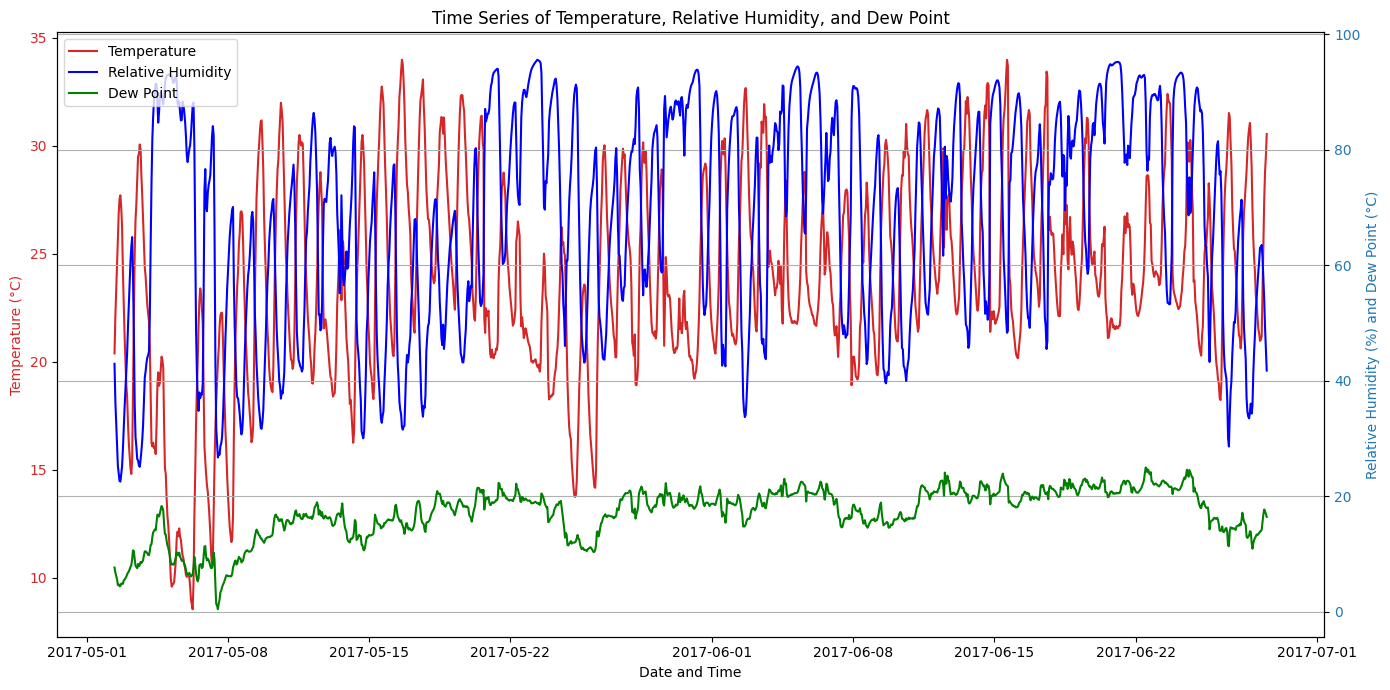

In [10]:
plot_time_series(ALL_DATA['10635576'].loc[common_index])

In [11]:


def plot_multiple_temperatures(dfs, culling_index ,labels=None):
    """
    Plots temperature time series from multiple DataFrames on the same plot.

    Parameters:
    dfs (list of pandas.DataFrame): List of DataFrames, each containing a 'Temp' column and a datetime index.
    labels (list of str, optional): List of labels for each DataFrame to use in the legend.

    Returns:
    None
    """



    # Check if DataFrames are provided
    if not dfs:
        raise ValueError("At least one DataFrame must be provided.")

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # If labels are not provided, create default labels
    if labels is None:
        labels = [f'DataFrame {i+1}' for i in range(len(dfs))]
    elif len(labels) != len(dfs):
        raise ValueError("The number of labels must match the number of DataFrames.")

    # Define colors for different DataFrames
    colors = [
        'tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]

    # Loop over the DataFrames
    for i, df in enumerate(dfs):

        df = df.loc[culling_index]
        
        # Check if 'Temp' column exists
        if 'Temp' not in df.columns:
            raise ValueError(f"DataFrame {i+1} is missing the 'Temp' column.")

        # Check if the index is a DatetimeIndex
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError(f"DataFrame {i+1} does not have a DatetimeIndex.")

        # Plot Temperature against index
        ax.plot(df.index, df['Temp'], label=labels[i], color=colors[i % len(colors)])

    # Formatting the plot
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Temperature (°C)')
    ax.set_ylim(5, 40)  # Adjust as needed
    ax.set_title('Temperature Time Series from Multiple DataFrames')
    ax.legend()
    ax.grid(True)

    # Rotate date labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45)

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Display the plot
    plt.show()


In [12]:
l = [ALL_DATA[i] for i in ALL_DATA]

In [13]:
l

[0                        Date       Temp         RH      DewPt
 Datetime                                                      
 2015-04-03 09:00:00  04/03/15  20.200864  63.170333  13.182963
 2015-04-03 10:00:00  04/03/15  23.187222  47.401083  11.649537
 2015-04-03 11:00:00  04/03/15  24.795370  38.789167  10.149676
 2015-04-03 12:00:00  04/03/15  26.628750  33.175083   9.372917
 2015-04-03 13:00:00  04/03/15  27.591852  28.475667   7.899630
 ...                       ...        ...        ...        ...
 2015-10-06 14:00:00  10/06/15  24.768472  55.489667  15.557963
 2015-10-06 15:00:00  10/06/15  25.700278  56.475417  16.696343
 2015-10-06 16:00:00  10/06/15  25.750556  57.163250  16.930556
 2015-10-06 17:00:00  10/06/15  24.574074  60.893750  16.775926
 2015-10-06 18:00:00  10/06/15  23.073778  66.068200  16.597222
 
 [8940 rows x 4 columns],
 0                        Date       Temp         RH      DewPt
 Datetime                                                      
 2015-04-03 

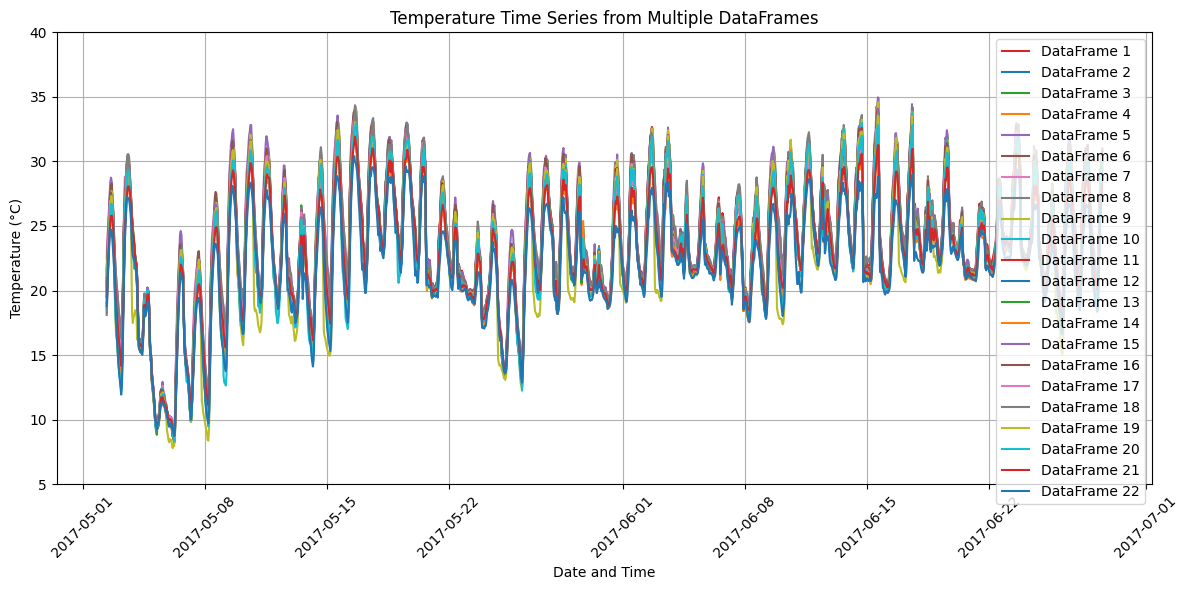

In [14]:
plot_multiple_temperatures(l,common_index)